In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-plate-detection/annotations/Cars339.xml
/kaggle/input/car-plate-detection/annotations/Cars13.xml
/kaggle/input/car-plate-detection/annotations/Cars74.xml
/kaggle/input/car-plate-detection/annotations/Cars16.xml
/kaggle/input/car-plate-detection/annotations/Cars291.xml
/kaggle/input/car-plate-detection/annotations/Cars236.xml
/kaggle/input/car-plate-detection/annotations/Cars429.xml
/kaggle/input/car-plate-detection/annotations/Cars132.xml
/kaggle/input/car-plate-detection/annotations/Cars251.xml
/kaggle/input/car-plate-detection/annotations/Cars51.xml
/kaggle/input/car-plate-detection/annotations/Cars165.xml
/kaggle/input/car-plate-detection/annotations/Cars313.xml
/kaggle/input/car-plate-detection/annotations/Cars240.xml
/kaggle/input/car-plate-detection/annotations/Cars201.xml
/kaggle/input/car-plate-detection/annotations/Cars412.xml
/kaggle/input/car-plate-detection/annotations/Cars227.xml
/kaggle/input/car-plate-detection/annotations/Cars145.xml
/kaggle/input/car-

# ***Importing Necessary Modules***

In [3]:
import os
import cv2 
import shutil
import numpy as np 
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split

import torch
print(f'{torch.cuda.is_available()=}')
print(f'{torch.cuda.device_count()=}')

torch.cuda.is_available()=True
torch.cuda.device_count()=2


# **Importing Ultralytics****

In [4]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 651.4 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.0/872.0 kB 5.9 MB/s eta 0:00:0000:0100:01


# **Load Dataset ****

In [5]:
dataset_path= '/kaggle/input/car-plate-detection'

# **Extract num from filename****

In [6]:
import re 
def num_in_string(filename):
    match= re.search(r'(\d+)',filename)
    if match:
        return int(match.group(0))
    else:
        return 0

In [7]:
print(num_in_string("file123.txt"))

123


# **Define a Dictionary ****

In [8]:
labels_dict= dict(img_path=[],
                 xmin=[],
                 xmax=[],
                 ymin=[],
                 ymax=[],
                 img_w=[],
                 img_h=[])

In [9]:
labels_dict

{'img_path': [],
 'xmin': [],
 'xmax': [],
 'ymin': [],
 'ymax': [],
 'img_w': [],
 'img_h': []}

# **Extract xml files****

In [10]:
xml_files=glob(f'{dataset_path}/annotations/*.xml')

               
print(xml_files)

['/kaggle/input/car-plate-detection/annotations/Cars339.xml', '/kaggle/input/car-plate-detection/annotations/Cars13.xml', '/kaggle/input/car-plate-detection/annotations/Cars74.xml', '/kaggle/input/car-plate-detection/annotations/Cars16.xml', '/kaggle/input/car-plate-detection/annotations/Cars291.xml', '/kaggle/input/car-plate-detection/annotations/Cars236.xml', '/kaggle/input/car-plate-detection/annotations/Cars429.xml', '/kaggle/input/car-plate-detection/annotations/Cars132.xml', '/kaggle/input/car-plate-detection/annotations/Cars251.xml', '/kaggle/input/car-plate-detection/annotations/Cars51.xml', '/kaggle/input/car-plate-detection/annotations/Cars165.xml', '/kaggle/input/car-plate-detection/annotations/Cars313.xml', '/kaggle/input/car-plate-detection/annotations/Cars240.xml', '/kaggle/input/car-plate-detection/annotations/Cars201.xml', '/kaggle/input/car-plate-detection/annotations/Cars412.xml', '/kaggle/input/car-plate-detection/annotations/Cars227.xml', '/kaggle/input/car-plate-de

In [11]:
for filename in sorted(xml_files,key= num_in_string):
    info= xet.parse(filename)
    root= info.getroot()
    #print(info)
    #print(root)
    
    
    member_object= root.find('object')
    labels_info= member_object.find('bndbox')
   #print(member_object,labels_info)
    
    
    xmin= int(labels_info.find('xmin').text)
    xmax= int(labels_info.find('xmax').text)
    ymin= int(labels_info.find('ymin').text)
    ymax= int(labels_info.find('ymax').text)
    #print(xmin,xmax,ymin,ymax)
    
    img_name=root.find('filename').text
    img_path=os.path.join(dataset_path,'images',img_name)
    #print(imag_name,img_path)
    
    height,width, _ =cv2.imread(img_path).shape
    #print(height,width)
    
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)

In [12]:
dataset=pd.DataFrame(labels_dict)
print(dataset)

                                              img_path  xmin  xmax  ymin  \
0    /kaggle/input/car-plate-detection/images/Cars0...   226   419   125   
1    /kaggle/input/car-plate-detection/images/Cars1...   134   262   128   
2    /kaggle/input/car-plate-detection/images/Cars2...   229   270   176   
3    /kaggle/input/car-plate-detection/images/Cars3...   142   261   128   
4    /kaggle/input/car-plate-detection/images/Cars4...   156   503    82   
..                                                 ...   ...   ...   ...   
428  /kaggle/input/car-plate-detection/images/Cars4...   142   258   128   
429  /kaggle/input/car-plate-detection/images/Cars4...    86   208   166   
430  /kaggle/input/car-plate-detection/images/Cars4...    38   116   159   
431  /kaggle/input/car-plate-detection/images/Cars4...    55   343    82   
432  /kaggle/input/car-plate-detection/images/Cars4...    95   196   258   

     ymax  img_w  img_h  
0     173    500    268  
1     160    400    248  
2     193

# ***Spliting the dataset***

In [13]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(dataset,test_size=1/10,random_state=42)
train,val=train_test_split(train,train_size=8/9,random_state=42)

In [14]:
print(f'''
len(train)={len(train)}
len(test)={len(test)}
len(val)={len(val)}
''')


len(train)=345
len(test)=44
len(val)=44



In [15]:
print(train)

                                              img_path  xmin  xmax  ymin  \
124  /kaggle/input/car-plate-detection/images/Cars1...   305   320   256   
315  /kaggle/input/car-plate-detection/images/Cars3...    12   385    98   
282  /kaggle/input/car-plate-detection/images/Cars2...    37   319   145   
236  /kaggle/input/car-plate-detection/images/Cars2...   223   250   106   
112  /kaggle/input/car-plate-detection/images/Cars1...    49   164   135   
..                                                 ...   ...   ...   ...   
110  /kaggle/input/car-plate-detection/images/Cars1...   286   328   133   
255  /kaggle/input/car-plate-detection/images/Cars2...   116   273   156   
292  /kaggle/input/car-plate-detection/images/Cars2...    91   137   187   
54   /kaggle/input/car-plate-detection/images/Cars5...   148   257    61   
199  /kaggle/input/car-plate-detection/images/Cars1...    59   310    88   

     ymax  img_w  img_h  
124   267    400    267  
315   181    400    300  
282   203

# ***Convert Data in the YOLO Format***

In [16]:
def make_split_folder_in_yolo_format(split_name,split_df):
    labels_path=os.path.join('datasets','cars_license_plate_new',split_name,'labels')
    images_path=os.path.join('datasets','cars_license_plate_new',split_name,'images')
    
    os.makedirs(labels_path)
    os.makedirs(images_path)
    
    for _,row in split_df.iterrows():
        img_name,img_extention = os.path.splitext(os.path.basename(row['img_path']))
        x_center= (row['xmin']+row['xmax'])/2/row['img_w']
        y_center= (row['ymin']+row['ymax'])/2/row['img_h']
        width= (row['xmax']-row['xmin'])/row['img_w']
        height= (row['ymax']-row['ymin'])/row['img_h']
        
        label_path=os.path.join(labels_path,f'{img_name}.txt')
        with open(label_path,'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")
        shutil.copy(row['img_path'], os.path.join(images_path,img_name+img_extention))

    print(f"created '{images_path}' and '{labels_path}' ")

In [17]:
make_split_folder_in_yolo_format('train',train)
make_split_folder_in_yolo_format('test',test)
make_split_folder_in_yolo_format('val',val)


created 'datasets/cars_license_plate_new/train/images' and 'datasets/cars_license_plate_new/train/labels' 
created 'datasets/cars_license_plate_new/test/images' and 'datasets/cars_license_plate_new/test/labels' 
created 'datasets/cars_license_plate_new/val/images' and 'datasets/cars_license_plate_new/val/labels' 


# ***Create a yaml file***

In [18]:
dataset_yaml='''
path: cars_license_plate_new
train: train/images
test: test/images
val: val/images
nc: 1
names: ['license_plate']
'''

with open('dataset.yaml','w') as file:
    file.write(dataset_yaml)

# ***Loading YOLO model***

In [19]:
from ultralytics import YOLO

# ***Define model***

In [20]:
model = YOLO('yolov8l.pt')

100%|██████████| 83.7M/83.7M [00:00<00:00, 330MB/s]


# ***Train the model***

In [21]:
model.train(data='dataset.yaml',epochs=100,batch=16,device='cuda',imgsz=320,cache=True)

Ultralytics YOLOv8.2.86 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wid

100%|██████████| 755k/755k [00:00<00:00, 14.5MB/s]
2024-09-01 21:48:46,796	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-01 21:48:47,370	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.25M/6.25M [00:00<00:00, 75.7MB/s]


AMP: checks passed ✅


/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
train: Scanning /kaggle/working/datasets/cars_license_plate_new/train/labels... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<00:00, 438.27it/s]

train: New cache created: /kaggle/working/datasets/cars_license_plate_new/train/labels.cache



train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:01<00:00, 173.39it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/datasets/cars_license_plate_new/val/labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 452.53it/s]

val: New cache created: /kaggle/working/datasets/cars_license_plate_new/val/labels.cache



val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 179.73it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.76G      1.853      2.837      1.436         25        320: 100%|██████████| 22/22 [00:06<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all         44         44     0.0225      0.773     0.0424     0.0262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.32G       1.66      1.473      1.358         14        320: 100%|██████████| 22/22 [00:04<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.20it/s]

                   all         44         44     0.0225      0.773     0.0424     0.0262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.31G      1.693      1.307       1.42         15        320: 100%|██████████| 22/22 [00:04<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.19it/s]

                   all         44         44     0.0225      0.773     0.0424     0.0262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.21G      1.729      1.286      1.418         17        320: 100%|██████████| 22/22 [00:04<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.27it/s]

                   all         44         44     0.0225      0.773     0.0424     0.0262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.21G      1.685      1.321      1.372         16        320: 100%|██████████| 22/22 [00:04<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]

                   all         44         44     0.0225      0.773     0.0424     0.0262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.32G      1.768      1.285      1.441         15        320: 100%|██████████| 22/22 [00:04<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.78it/s]

                   all         44         44     0.0225      0.773     0.0424     0.0262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.21G      1.738      1.262      1.466         16        320: 100%|██████████| 22/22 [00:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.88it/s]

                   all         44         44     0.0225      0.773     0.0424     0.0262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.32G      1.617      1.183      1.365         24        320: 100%|██████████| 22/22 [00:04<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

                   all         44         44      0.819      0.545      0.628      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.21G      1.695      1.183      1.373         14        320: 100%|██████████| 22/22 [00:04<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]

                   all         44         44      0.658       0.25        0.3       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.31G      1.574      1.047      1.326         18        320: 100%|██████████| 22/22 [00:05<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

                   all         44         44      0.608      0.455      0.521      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.21G      1.565      1.059      1.371         19        320: 100%|██████████| 22/22 [00:04<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         44         44      0.577      0.659      0.678      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.31G      1.576      1.045      1.334         21        320: 100%|██████████| 22/22 [00:05<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]

                   all         44         44      0.759      0.545      0.708      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.21G       1.55      1.005      1.298         25        320: 100%|██████████| 22/22 [00:05<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]

                   all         44         44      0.886      0.682      0.786      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.31G      1.412     0.9539      1.272         25        320: 100%|██████████| 22/22 [00:05<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

                   all         44         44      0.762      0.801      0.794      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.21G      1.421     0.9556      1.286         13        320: 100%|██████████| 22/22 [00:05<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]

                   all         44         44      0.806      0.886      0.893      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.32G      1.463     0.9682      1.288         14        320: 100%|██████████| 22/22 [00:05<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]

                   all         44         44      0.909      0.659      0.778      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.25G      1.488     0.9259       1.27         25        320: 100%|██████████| 22/22 [00:05<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]

                   all         44         44      0.741      0.841      0.841      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.32G      1.339      0.878      1.217         16        320: 100%|██████████| 22/22 [00:05<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         44         44      0.746      0.727      0.757      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.21G      1.404     0.9002      1.261         16        320: 100%|██████████| 22/22 [00:04<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]

                   all         44         44      0.793       0.75      0.831      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       3.3G       1.42     0.8676      1.234         22        320: 100%|██████████| 22/22 [00:05<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]

                   all         44         44      0.811      0.782      0.813      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.21G      1.345     0.8681      1.233         16        320: 100%|██████████| 22/22 [00:04<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

                   all         44         44      0.777      0.773      0.838      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.29G      1.318     0.8197      1.212         18        320: 100%|██████████| 22/22 [00:04<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]

                   all         44         44      0.788      0.886      0.878      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.21G      1.282      0.794      1.191         20        320: 100%|██████████| 22/22 [00:04<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]

                   all         44         44      0.876      0.727      0.868      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.32G      1.337     0.8114      1.227         14        320: 100%|██████████| 22/22 [00:05<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.18it/s]

                   all         44         44      0.738      0.727      0.769      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.21G      1.331      0.835      1.225         19        320: 100%|██████████| 22/22 [00:04<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]

                   all         44         44      0.721      0.841      0.823       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.32G      1.296     0.8333      1.196         17        320: 100%|██████████| 22/22 [00:05<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]

                   all         44         44       0.81      0.659      0.775      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.28G      1.286     0.8164      1.223         11        320: 100%|██████████| 22/22 [00:05<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]

                   all         44         44      0.809      0.773       0.83      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.31G      1.269     0.7785       1.16         19        320: 100%|██████████| 22/22 [00:05<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         44         44      0.694      0.773      0.727      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.21G      1.252     0.7388      1.154         17        320: 100%|██████████| 22/22 [00:05<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]

                   all         44         44      0.838       0.75      0.835      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       3.3G      1.224     0.7719      1.161         15        320: 100%|██████████| 22/22 [00:05<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]

                   all         44         44      0.806      0.795      0.834      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.22G      1.244     0.7534      1.198         12        320: 100%|██████████| 22/22 [00:04<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]

                   all         44         44      0.825      0.773       0.81      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       3.3G      1.227      0.771      1.173         21        320: 100%|██████████| 22/22 [00:05<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]

                   all         44         44      0.886      0.704      0.834      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       3.2G      1.216     0.7533      1.167         27        320: 100%|██████████| 22/22 [00:05<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

                   all         44         44      0.834      0.773      0.843      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       3.3G      1.167      0.738      1.138         20        320: 100%|██████████| 22/22 [00:05<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]

                   all         44         44      0.773       0.75      0.797      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.21G      1.166     0.6778      1.149         18        320: 100%|██████████| 22/22 [00:04<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         44         44      0.768      0.828      0.819       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.32G       1.18     0.7194      1.163         14        320: 100%|██████████| 22/22 [00:05<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

                   all         44         44      0.749      0.814      0.851      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       3.2G      1.135     0.7009      1.136         17        320: 100%|██████████| 22/22 [00:04<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]

                   all         44         44      0.795      0.818      0.808      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.31G      1.158     0.6791      1.133         14        320: 100%|██████████| 22/22 [00:05<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]

                   all         44         44      0.826      0.773      0.805      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.25G      1.129     0.7127       1.15         11        320: 100%|██████████| 22/22 [00:05<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

                   all         44         44      0.819      0.864      0.864      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.32G      1.107     0.6845      1.135         19        320: 100%|██████████| 22/22 [00:05<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]

                   all         44         44      0.854      0.795      0.829      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.21G      1.109     0.6759      1.157         14        320: 100%|██████████| 22/22 [00:05<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         44         44      0.795      0.864      0.861      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.31G      1.134      0.661      1.115         12        320: 100%|██████████| 22/22 [00:05<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]

                   all         44         44      0.798      0.818      0.832      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.27G      1.044     0.6483      1.086         18        320: 100%|██████████| 22/22 [00:05<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

                   all         44         44      0.826      0.863      0.853      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.29G      1.061     0.6413      1.116         15        320: 100%|██████████| 22/22 [00:05<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]

                   all         44         44      0.837      0.841      0.865      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.21G      1.112     0.6364      1.097         16        320: 100%|██████████| 22/22 [00:05<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         44         44       0.84      0.841      0.838      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       3.3G      1.044     0.6236      1.112         14        320: 100%|██████████| 22/22 [00:05<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]

                   all         44         44      0.844      0.818      0.834      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.27G     0.9814     0.6007      1.062         11        320: 100%|██████████| 22/22 [00:05<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

                   all         44         44      0.812      0.841      0.856      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.29G      1.033     0.6237      1.071         21        320: 100%|██████████| 22/22 [00:05<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         44         44      0.882      0.773      0.871      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.27G      1.035     0.6191      1.093         22        320: 100%|██████████| 22/22 [00:05<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

                   all         44         44      0.786      0.864      0.846      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.31G      1.036     0.6154       1.09         16        320: 100%|██████████| 22/22 [00:05<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]

                   all         44         44      0.804      0.864      0.846      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.28G     0.9965     0.6038      1.065         20        320: 100%|██████████| 22/22 [00:05<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]

                   all         44         44      0.798      0.864      0.853      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       3.3G     0.9811     0.6123      1.068         13        320: 100%|██████████| 22/22 [00:05<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

                   all         44         44      0.872      0.818      0.885      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.21G     0.9693     0.5883      1.046         15        320: 100%|██████████| 22/22 [00:04<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

                   all         44         44      0.937       0.75      0.865      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.31G     0.9307     0.5595      1.056         19        320: 100%|██████████| 22/22 [00:05<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

                   all         44         44      0.923      0.813      0.868      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.27G     0.9566      0.565      1.054         11        320: 100%|██████████| 22/22 [00:05<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]

                   all         44         44      0.762      0.864      0.834      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.31G     0.9292      0.552      1.027         11        320: 100%|██████████| 22/22 [00:05<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]

                   all         44         44      0.787      0.864      0.868      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.27G     0.9042     0.5269      1.027         18        320: 100%|██████████| 22/22 [00:04<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]

                   all         44         44      0.793      0.886      0.907      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.31G     0.9362     0.5565      1.044         21        320: 100%|██████████| 22/22 [00:05<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]

                   all         44         44      0.802      0.818       0.87      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.25G     0.9201     0.5468      1.059         14        320: 100%|██████████| 22/22 [00:05<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]

                   all         44         44       0.83      0.841      0.869      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.31G     0.9599     0.5627      1.054         20        320: 100%|██████████| 22/22 [00:05<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         44         44      0.878      0.815      0.877      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       3.2G     0.9196     0.5293      1.063         22        320: 100%|██████████| 22/22 [00:04<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]

                   all         44         44       0.78      0.864       0.89      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.31G     0.9391     0.5567      1.051         12        320: 100%|██████████| 22/22 [00:05<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]

                   all         44         44      0.853      0.818      0.887      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.24G      0.893     0.5266      1.041         14        320: 100%|██████████| 22/22 [00:04<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]

                   all         44         44       0.92      0.783      0.887      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       3.3G     0.9001     0.5236      1.062         13        320: 100%|██████████| 22/22 [00:05<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]

                   all         44         44      0.866      0.773      0.877      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.25G     0.8331     0.5055      1.028         20        320: 100%|██████████| 22/22 [00:05<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]

                   all         44         44      0.886      0.795      0.869      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       3.3G     0.8452     0.4906      1.006         20        320: 100%|██████████| 22/22 [00:05<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]

                   all         44         44      0.885      0.818      0.881       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.22G     0.8547      0.513      1.033         14        320: 100%|██████████| 22/22 [00:05<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]

                   all         44         44      0.773      0.854      0.866      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       3.3G     0.8505     0.4962      1.014         19        320: 100%|██████████| 22/22 [00:05<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]

                   all         44         44      0.861      0.795      0.883      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.21G     0.8627     0.5142      1.038         20        320: 100%|██████████| 22/22 [00:04<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]

                   all         44         44       0.84      0.835      0.864      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.32G     0.8746     0.5028      1.022         12        320: 100%|██████████| 22/22 [00:05<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]

                   all         44         44       0.85      0.795      0.882      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.27G     0.8657     0.4972      1.025         15        320: 100%|██████████| 22/22 [00:04<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

                   all         44         44       0.77      0.841      0.841       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.31G     0.8043     0.4792     0.9879         15        320: 100%|██████████| 22/22 [00:05<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

                   all         44         44      0.872      0.795      0.839      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.27G     0.8248     0.4877     0.9774         20        320: 100%|██████████| 22/22 [00:04<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.18it/s]

                   all         44         44      0.879      0.818      0.848      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.29G     0.8058     0.4666     0.9882         23        320: 100%|██████████| 22/22 [00:05<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]

                   all         44         44      0.751      0.841      0.844      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.21G      0.832     0.4655      1.005         16        320: 100%|██████████| 22/22 [00:04<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]

                   all         44         44      0.791      0.859      0.869      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.31G     0.7882     0.4568     0.9953         20        320: 100%|██████████| 22/22 [00:05<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]

                   all         44         44      0.821      0.841      0.891      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.21G     0.8048     0.4632      1.017         15        320: 100%|██████████| 22/22 [00:04<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]

                   all         44         44      0.847      0.795       0.87      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       3.3G      0.795     0.4592     0.9916         20        320: 100%|██████████| 22/22 [00:05<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         44         44      0.788      0.864      0.869      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.21G      0.799     0.4629     0.9948         24        320: 100%|██████████| 22/22 [00:04<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]

                   all         44         44      0.877      0.818      0.882       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       3.3G     0.7479     0.4441     0.9782         17        320: 100%|██████████| 22/22 [00:05<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

                   all         44         44      0.756      0.914      0.883      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.27G     0.7721     0.4479     0.9784         18        320: 100%|██████████| 22/22 [00:04<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]

                   all         44         44      0.799      0.909      0.851      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.31G     0.7711     0.4472      1.005         19        320: 100%|██████████| 22/22 [00:05<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         44         44      0.791      0.886      0.853       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.21G      0.747     0.4202     0.9682         19        320: 100%|██████████| 22/22 [00:04<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]

                   all         44         44      0.877       0.81      0.857       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.32G     0.7243     0.4461     0.9696         20        320: 100%|██████████| 22/22 [00:05<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]

                   all         44         44      0.839      0.864      0.879      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.21G      0.744     0.4489     0.9676         15        320: 100%|██████████| 22/22 [00:05<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]

                   all         44         44      0.879      0.818      0.873      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.31G     0.7137     0.4148     0.9759         18        320: 100%|██████████| 22/22 [00:05<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]

                   all         44         44      0.892      0.818      0.885      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.27G     0.6958     0.4015     0.9566         14        320: 100%|██████████| 22/22 [00:04<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]

                   all         44         44      0.877      0.841      0.881      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.32G     0.7202     0.4209     0.9565         13        320: 100%|██████████| 22/22 [00:04<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]

                   all         44         44      0.808      0.886      0.877      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.21G     0.7081     0.4269     0.9725         22        320: 100%|██████████| 22/22 [00:05<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]

                   all         44         44      0.812      0.909      0.892      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.32G     0.6919     0.4052       0.95         19        320: 100%|██████████| 22/22 [00:05<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]

                   all         44         44      0.825      0.859      0.873      0.496


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.21G     0.9673     0.5238      1.072          9        320: 100%|██████████| 22/22 [00:05<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]

                   all         44         44      0.899      0.809      0.865        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       3.3G      1.003     0.5029      1.094          9        320: 100%|██████████| 22/22 [00:05<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]

                   all         44         44      0.905      0.773      0.885      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.21G     0.9725      0.484      1.091          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]

                   all         44         44      0.832      0.818      0.873      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       3.3G     0.9579     0.4771      1.072          9        320: 100%|██████████| 22/22 [00:05<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]

                   all         44         44      0.815      0.818      0.857      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.21G     0.9312     0.4588       1.05          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]

                   all         44         44      0.812      0.818      0.874      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.33G     0.9224     0.4638      1.066          9        320: 100%|██████████| 22/22 [00:05<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]

                   all         44         44      0.854      0.801      0.883      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.21G     0.9168      0.467      1.049          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]

                   all         44         44      0.898      0.818      0.886      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       3.3G     0.8905     0.4426      1.026          8        320: 100%|██████████| 22/22 [00:04<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]

                   all         44         44      0.895      0.818      0.886      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.21G     0.8779     0.4476      1.049          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]

                   all         44         44      0.923      0.815      0.886      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       3.3G     0.8694     0.4487      1.043          9        320: 100%|██████████| 22/22 [00:05<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]

                   all         44         44      0.922      0.808      0.888      0.511



100 epochs completed in 0.206 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 87.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 87.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.86 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 268 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


                   all         44         44       0.78      0.884      0.883      0.532
Speed: 0.1ms preprocess, 4.5ms inference, 0.0ms loss, 9.0ms postprocess per image
Results saved to runs/detect/train


lr/pg0,▂▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▂▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▂▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▁▁▆▆▇▇▇██▇▇▇▇██████████████████████████
metrics/mAP50-95(B),▁▁▁▅▅▆▆▇▇▇▆▆▇▇▇▇▇▇▇▇▇██▇▇▇██▇▇██████████
metrics/precision(B),▁▁▁▇▅██▇▇█▇▆▇▇▇▇▇▇▇▇▇█▇▇▇█▇▇█▇▇█▇▇█▇█▇█▇
metrics/recall(B),▅▅▅▁▃▄▃▅▅▅▃▅▅▅▆▇▇▇▆▇▇▆▇▇▇▅▇▇▆▇▆▆█▇▇█▅▆▆█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▃▃▂▂


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7aa634435750>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# ***Results of training directory***

In [22]:
log_dir = max(glob('runs/detect/train*'), key= num_in_string)

results = pd.read_csv(os.path.join(log_dir,'results.csv'))


In [23]:
results.columns= results.columns.str.strip()
epochs=results.index+1
print(epochs)

RangeIndex(start=1, stop=101, step=1)


In [24]:
results.columns

Index(['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')

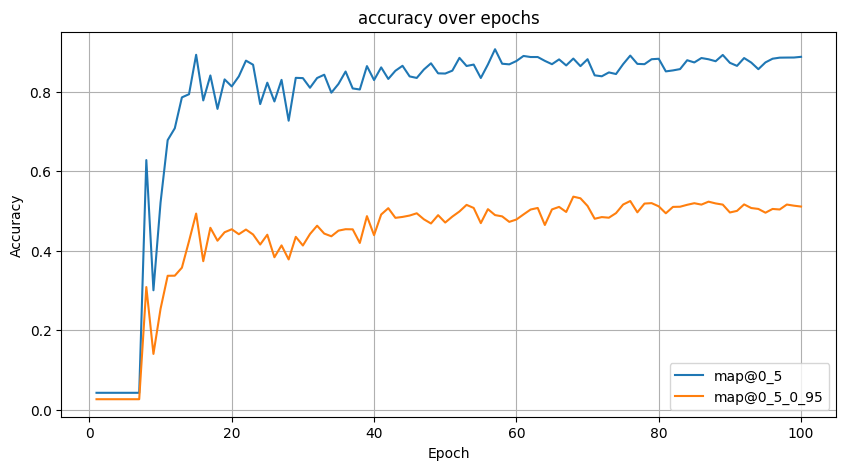

In [25]:
map_0_5= results['metrics/mAP50(B)']
map_0_5_0_95= results['metrics/mAP50-95(B)']
plt.figure(figsize=(10,5))
plt.plot(epochs,map_0_5, label='map@0_5')
plt.plot(epochs,map_0_5_0_95, label='map@0_5_0_95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('accuracy over epochs')
plt.legend()
plt.grid()
plt.show()

# ***Save model ***

In [26]:
model.save('license_plate_detection_model.pt')

# ***make prediction ***

In [27]:
results= model.predict('/kaggle/input/car-plate-detection/images/Cars121.png')


image 1/1 /kaggle/input/car-plate-detection/images/Cars121.png: 256x320 2 license_plates, 49.5ms
Speed: 0.8ms preprocess, 49.5ms inference, 1.5ms postprocess per image at shape (1, 3, 256, 320)


In [28]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'license_plate'}
 obb: None
 orig_img: array([[[1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         ...,
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0]],
 
        [[1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         ...,
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0]],
 
        [[1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         ...,
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0]],
 
        ...,
 
        [[1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         ...,
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0]],
 
        [[1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         ...,
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0]],
 
        [[1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         ...,
         [1, 0, 0],
         [1, 0, 

In [29]:
os.listdir('/kaggle/working/runs/detect')

['train']

In [32]:
image= cv2.imread('/kaggle/input/car-plate-detection/images/Cars140.png')
image= cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.6592], device='cuda:0')
data: tensor([[334.6840, 192.8149, 356.9818, 202.0347,   0.6592,   0.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (300, 400)
shape: torch.Size([1, 6])
xywh: tensor([[345.8329, 197.4248,  22.2978,   9.2198]], device='cuda:0')
xywhn: tensor([[0.8646, 0.6581, 0.0557, 0.0307]], device='cuda:0')
xyxy: tensor([[334.6840, 192.8149, 356.9818, 202.0347]], device='cuda:0')
xyxyn: tensor([[0.8367, 0.6427, 0.8925, 0.6734]], device='cuda:0')
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.6557], device='cuda:0')
data: tensor([[190.3702, 147.7447, 212.2261, 156.3982,   0.6557,   0.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (300, 400)
shape: torch.Size([1, 6])
xywh: tensor([[201.2982, 152.0714,  21.8559,   8.6535]], device='cuda:0')
xywhn: tensor([[0.5032, 0.5069, 0.0546, 0.

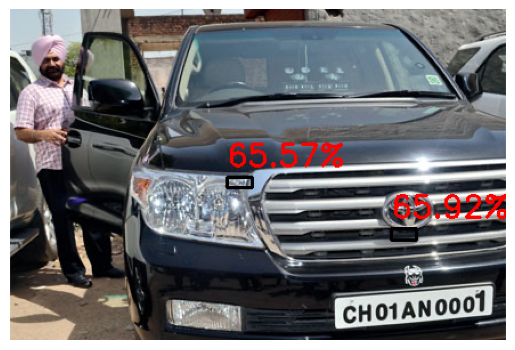

In [33]:
for result in results:
    for box in result.boxes:
        print(box)
        x1,y1,x2,y2= map(int,box.xyxy[0])
        confidence = box.conf[0]
        
        cv2.rectangle(image,(x1,y1),(x2,y2),(0.255,0),2)
        cv2.putText(image,f'{confidence*100:.2f}%', (x1,y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX,0.9,(255,0,0),2)
plt.imshow(image)
plt.axis('off')
plt.show()

